In [2]:
## QUESTION 1 CORRELATION AND COVARIANCE
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt

X = np.reshape(genfromtxt('time_with_loved_ones.csv', delimiter='\n'), (-1,1))
Y = np.reshape(genfromtxt('happiness_level.csv', delimiter='\n'), (-1,1))
def covar(X, Y): # my covariance function
    n = len(X)
    mean_X = np.mean(X)
    mean_Y = np.mean(Y)
    cov = np.sum((X - mean_X) * (Y - mean_Y)) / n
    return cov

my_cov = covar(X, Y)
py_cov = np.cov(X, Y, rowvar=False, bias= True)[0, 1]
print("Covariance (My Function):", my_cov)
print("Covariance (Python):", py_cov)

def correl(X, Y):  # my correlation function
    cov = covar(X, Y)
    mean_X = np.mean(X)
    mean_Y = np.mean(Y)
    var_X = np.sum((X - mean_X)**2) / len(X)
    var_Y = np.sum((Y - mean_Y)**2) / len(Y)
    corr = cov / np.sqrt(var_X * var_Y)
    return corr

my_correl = correl(X, Y)
py_correl = np.corrcoef(X.flatten(), Y.flatten())[0, 1]

print("\nCorrelation (My Function):", my_correl)
print("Correlation (Python):", py_correl)

Covariance (My Function): 13.446017300664
Covariance (Python): 13.446017300663998

Correlation (My Function): 0.9863449783003244
Correlation (Python): 0.9863449783003242


largest eigvals:  5795006.092201104 7560.365260294613


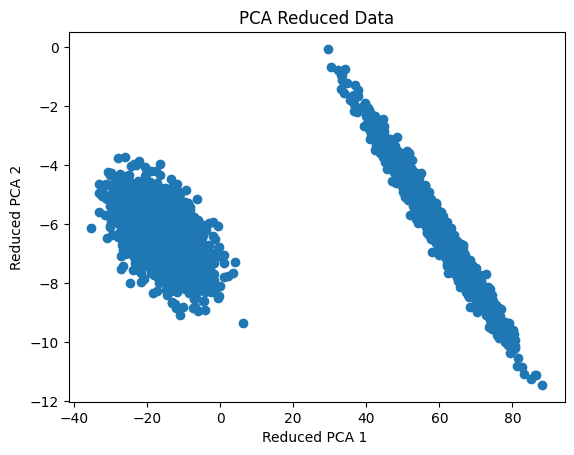

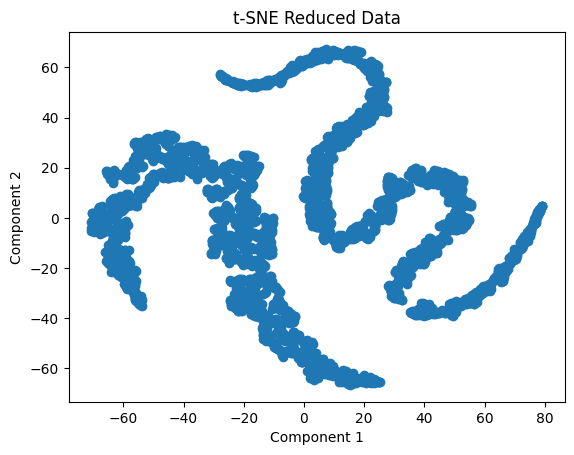

In [3]:
# ## QUESTION 2 PCA
X = np.genfromtxt('Pollution_data.csv', delimiter=',')
C = np.eye(4000) - (1/4000) * np.ones((4000, 4000)) # centering matrix
Q = np.dot(np.dot(X.T, C), X) # find the covariance matrix
[D, V] = np.linalg.eigh(Q)
largest_indices = np.argsort(D)[::-1][:5]  
largest_eigenvalues = D[largest_indices]
# from this, it seems that the last 2 eigvalues are the largest, the rest are very tiny
print ("largest eigvals: ", D[len(D)-1], D[len(D)-2]) # 1st and 2nd largest eigvalues
# SO, WE SHOULD PICK THE LAST TWO EIGENVECTORS AS THE ANSWER AND REDUCE TO 2 DIMENSIONS
projected_data = np.dot(X, V[:, -2:])

plt.scatter(-projected_data[:, 1], projected_data[:, 0])  # Flip the second component
plt.title("PCA Reduced Data")
plt.xlabel("Reduced PCA 1 ")
plt.ylabel("Reduced PCA 2")
plt.show()

# from sklearn.decomposition import PCA
# # Apply PCA for dimensionality reduction
# pca = PCA(n_components=2)
# reduced_data = pca.fit_transform(X)

# # Visualize the reduced data
# plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.5)
# plt.title("PCA Reduced Data")
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.show()

## USING TSNE 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title("t-SNE Reduced Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


In [1]:
# noticing a split in the data, we can separate the data into two groups
group1 = projected_data[projected_data[:, 1] > 20]
group2 = projected_data[projected_data[:, 1] <= 20]

cov_1 = np.cov(group1, rowvar=False)
cov_2 = np.cov(group2, rowvar=False)

var_1 = np.trace(cov_1)
var_2 = np.trace(cov_2)

print("Variance of group 1:", var_1)
print("Variance of group 2:", var_2)
if var_1 > var_2:
    print("Group 1 is the group with children impacted by pollution.")
else:
    print("Group 2 is the group with children impacted by pollution.")



## LOGISTIC REGRESSION 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score

impacted = group1 if var_1 > var_2 else group2
not_impacted = group2 if var_1 > var_2 else group1
impacted_labels = np.ones(len(impacted))  # label 1 for impacted 
not_impacted_labels = np.zeros(len(not_impacted))  # label 0 for not impacted 

X = np.vstack((impacted, not_impacted))
y = np.concatenate((impacted_labels, not_impacted_labels))

# 80 - 10 - 10 split into train test validate
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

class LogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=1000):
        self.learning_rate = learning_rate
        self.max_iter = max_iter

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X_train, y_train):
        self.w = np.zeros(X_train.shape[1])
        for _ in range(self.max_iter):
            linear_model = np.dot(X_train, self.w)
            y_pred = self.sigmoid(linear_model)
            gradient = np.dot(X_train.T, (y_pred - y_train)) / len(y_train)
            self.w -= self.learning_rate * gradient

    def predict(self, X):
        linear_model = np.dot(X, self.w)
        y_pred = self.sigmoid(linear_model)
        return np.round(y_pred).astype(int)

log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

y_pred_train = log_reg_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Logistic Regression Training Accuracy:", accuracy_train)

y_pred_val = log_reg_model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
print("Logistic Regression Validation Accuracy:", accuracy_val)

y_pred_test = log_reg_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Logistic Regression Test Accuracy:", accuracy_test)



class SVM:
    def __init__(self, learning_rate=0.01, lambd=0.01, num_iters=1000):
        self.learning_rate = learning_rate
        self.lambd = lambd
        self.num_iters = num_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.w = np.zeros(num_features)
        self.b = 0

        for _ in range(self.num_iters):
            for i, x_i in enumerate(X):
                condition = y[i] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.learning_rate * (2 * self.lambd * self.w)
                else:
                    self.w -= self.learning_rate * (2 * self.lambd * self.w - np.dot(x_i, y[i]))
                    self.b -= self.learning_rate * y[i]

    def predict(self, X):
        return np.sign(np.dot(X, self.w) - self.b)

svm_model = SVM()
svm_model.fit(X_train, y_train)

y_pred_train_svm = svm_model.predict(X_train)
accuracy_train_svm = accuracy_score(y_train, y_pred_train_svm)
print("SVM Training Accuracy:", accuracy_train_svm)

y_pred_val_svm = svm_model.predict(X_val)
accuracy_val_svm = accuracy_score(y_val, y_pred_val_svm)
print("SVM Validation Accuracy:", accuracy_val_svm)

y_pred_test_svm = svm_model.predict(X_test)
accuracy_test_svm = accuracy_score(y_test, y_pred_test_svm)
print("SVM Test Accuracy:", accuracy_test_svm)

kmeans = KMeans(n_clusters=2)
labels = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_
print ("centers: ", centers)

plt.scatter(X[:, 0], X[:, 1], c=labels, s = 50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker = 'X', s=50, label = 'cluster centers')
plt.title("KMeans Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
# nmi = normalized_mutual_info_score(labels, y)
# print("Normalized Mutual Information:", nmi)


# class KMeans:
#     def __init__(self, k=2, max_iter=1000):
#         self.k = k
#         self.max_iter = max_iter

#     def fit(self, X):
#         centroids_indices = np.random.choice(X.shape[0], self.k, replace=False)
#         self.centroids = X[centroids_indices]

#         labels = np.zeros(X.shape[0])
#         for _ in range(self.max_iter):
#             distances = np.linalg.norm(X - self.centroids[:, np.newaxis], axis=2)
#             labels = np.argmin(distances, axis=0)

#             new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.k)])
            
#             if np.allclose(self.centroids, new_centroids):
#                 break
                
#             self.centroids = new_centroids

#         return labels.astype(int)

# kmeans = KMeans(n_clusters=2)
# kmeans.fit(X)

# kmeans_model = KMeans(k=2)
# kmeans_labels = kmeans_model.fit(X_train)


NameError: name 'projected_data' is not defined